In [1]:
# Titanic dataset can be found https://www.kaggle.com/c/titanic/data
# This is a very basic introduction to ML via Random forest classifers

# Get the libraries you will need - NOTE - They are case sensitive
import pandas as pd
import numpy as np 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import scipy
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


In [2]:
#Now, we will read the data (my data is stored in a data folder in my wd)
#will read it directly into a dataframe

train = pd.read_csv(filepath_or_buffer='./data/train.csv')
test = pd.read_csv(filepath_or_buffer='./data/test.csv')

headers = train.columns
train.head()



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
#Looking at the data, there are some columns we can get rid of as they are not predictive (I BELIEVE, you may think otherwise...)
#Passengerid, ticket, name, SibSp, Parch, Cabin
# The axis specifies columns (0 would specify rows)
train = train.drop(['PassengerId', 'Ticket', 'Name', 'SibSp', 'Parch', 'Cabin'], axis=1)
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked
0,0,3,male,22.0,7.2500,S
1,1,1,female,38.0,71.2833,C
2,1,3,female,26.0,7.9250,S
3,1,1,female,35.0,53.1000,S
4,0,3,male,35.0,8.0500,S


In [4]:
#Now, look at the columns to see which ones are fully filled and which are not
nullCols = pd.isnull(train).sum() > 0
nullCols

Survived    False
Pclass      False
Sex         False
Age          True
Fare        False
Embarked     True
dtype: bool

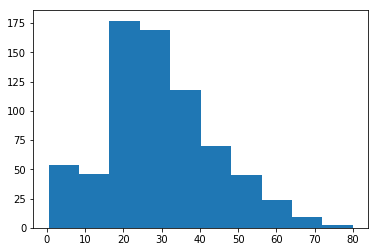

Mean Age: 29.69911764705882
Median Age: 28.0


In [5]:
# Now, think of suitable replacement values
# Age...

mean_age = np.mean(train['Age'].dropna())
median_age = np.median(train['Age'].dropna())

plt.hist(train['Age'].dropna())
plt.show()

print ('Mean Age: {}'.format(str(mean_age)))
print ('Median Age: {}'.format(str(median_age)))

In [6]:
# Could also look at the splits by gender
mean_split = train.groupby('Sex').mean()['Age']
mean_split



Sex
female    27.915709
male      30.726645
Name: Age, dtype: float64

In [7]:
# Everything is pretty even, so I will just take 28 as the replacement value
train['Age'] = train['Age'].fillna(28)
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked
0,0,3,male,22.0,7.2500,S
1,1,1,female,38.0,71.2833,C
2,1,3,female,26.0,7.9250,S
3,1,1,female,35.0,53.1000,S
4,0,3,male,35.0,8.0500,S


In [8]:
print (train.isnull().sum())
train.groupby('Embarked').count()

Survived    0
Pclass      0
Sex         0
Age         0
Fare        0
Embarked    2
dtype: int64


,Survived,Pclass,Sex,Age,Fare
Embarked,,,,,
C,168,168,168,168,168
Q,77,77,77,77,77
S,644,644,644,644,644


In [9]:
#As we are only actually missing 2 values from embarked, we can just fill them in with our most common value
#You could also exclude them if you wanted
train['Embarked'] = train['Embarked'].fillna('S')
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked
0,0,3,male,22.0,7.2500,S
1,1,1,female,38.0,71.2833,C
2,1,3,female,26.0,7.9250,S
3,1,1,female,35.0,53.1000,S
4,0,3,male,35.0,8.0500,S


In [10]:
# Now we have decided on our null values and planned out the varaibles we are going to use, we need to onehotencode our data
# One hot encoding is a way of using categorical variables in models
# Our categoricals are:
# - Sex
# - Embarked
from sklearn.preprocessing import OneHotEncoder

# First, we need to take out our target variable
y = train['Survived']
train = train.drop('Survived', axis = 1)
train.head()

,Pclass,Sex,Age,Fare,Embarked
0,3,male,22.0,7.2500,S
1,1,female,38.0,71.2833,C
2,3,female,26.0,7.9250,S
3,1,female,35.0,53.1000,S
4,3,male,35.0,8.0500,S


In [11]:
#onehot_mask = [True if x.dtype != 'Float64' else False for x in train.dtypes]
#onehot_mask
train.dtypes
train['Sex'] = pd.Categorical(train['Sex'])
train['Embarked'] = pd.Categorical(train['Embarked'])

train.head()

,Pclass,Sex,Age,Fare,Embarked
0,3,male,22.0,7.2500,S
1,1,female,38.0,71.2833,C
2,3,female,26.0,7.9250,S
3,1,female,35.0,53.1000,S
4,3,male,35.0,8.0500,S


In [12]:
# Get the dummy/onehot variables
# One hot encoding is the method of converting a categorical variable into colums of 1/0s

#First, need to see what columns we will want to encode, by looking at the datatypes of the columns
train.dtypes

Pclass         int64
Sex         category
Age          float64
Fare         float64
Embarked    category
dtype: object

In [13]:
#Clearly, sex and embarked are categoricals
#However, I would also class PClass as categorical as well
#Because it is numeric, but it could easily be character based (Ie, First Class, Second Class etc)

train = pd.get_dummies(train, columns=['Pclass', 'Sex', 'Embarked'])

In [14]:
# I would also personally log the financial variables (this is quite common, but not a strict rule)
# What is also common is to add 1 to each value, if you know the values are positive but contain zeros)
train['Fare'] = np.log(train['Fare']+1)
train.head()

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,22.0,2.110213,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,38.0,4.280593,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,26.0,2.188856,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,35.0,3.990834,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,35.0,2.202765,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [15]:
#Finally, we have to split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.2, random_state = 123)


print ('Train size: {}'.format(len(X_train.index)))
print ('Test size: {}'.format(len(X_test.index)))

Train size: 712
Test size: 179


In [16]:
# Now we can build the classifier
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=50
                            , criterion = 'gini'
                            , max_features = 'auto')

In [17]:
# Now we fit the classifier
clf = clf.fit(X=X_train, y=y_train)

In [18]:
scores = clf.score(X=X_test, y=y_test)
scores

0.84357541899441346

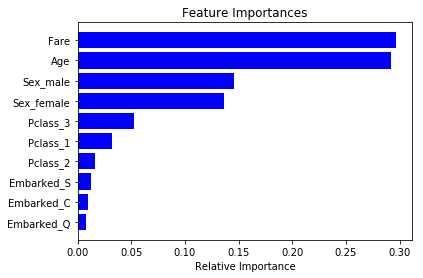

In [19]:
# An OK score...
# Lets look more closely at the results

importances = clf.feature_importances_
indices = np.argsort(importances)


# How about feature importance
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), train[indices])
plt.xlabel('Relative Importance')
plt.show()



In [30]:
# Interesting results. Generally follow rules that we would expect, with a few anomolies
# How about looking at what happens if we play with some of our parameters
criterion = ('gini', 'entropy')
n_estimators = range(1,101)

from collections import OrderedDict

scores = []
plt_dict = OrderedDict((label, []) for label in criterion)
for i in criterion:
    for j in n_estimators:
        clf = RandomForestClassifier(n_estimators=j
                            , criterion = i
                            , max_features = 'auto')
        clf = clf.fit(X=X_train, y=y_train)
        score = clf.score(X=X_test, y=y_test)
        plt_dict[str(i)].append((j, score))
        
        
plt_dict

OrderedDict([('gini',
              [(1, 0.76536312849162014),
               (2, 0.83798882681564246),
               (3, 0.81005586592178769),
               (4, 0.79329608938547491),
               (5, 0.81564245810055869),
               (6, 0.83798882681564246),
               (7, 0.84357541899441346),
               (8, 0.83240223463687146),
               (9, 0.84916201117318435),
               (10, 0.81564245810055869),
               (11, 0.84357541899441346),
               (12, 0.85474860335195535),
               (13, 0.82122905027932958),
               (14, 0.84357541899441346),
               (15, 0.84916201117318435),
               (16, 0.86033519553072624),
               (17, 0.82681564245810057),
               (18, 0.82681564245810057),
               (19, 0.84916201117318435),
               (20, 0.82681564245810057),
               (21, 0.83240223463687146),
               (22, 0.84916201117318435),
               (23, 0.83240223463687146),
               (24, 0

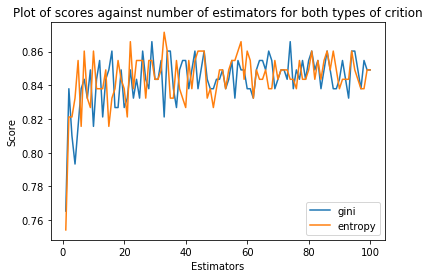

In [31]:
# Now plot it
for key, value in plt_dict.items():
    xs, ys = zip(*value)
    plt.plot(xs, ys, label = key)
    
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Plot of scores against number of estimators for both types of crition')
plt.legend()
plt.show()

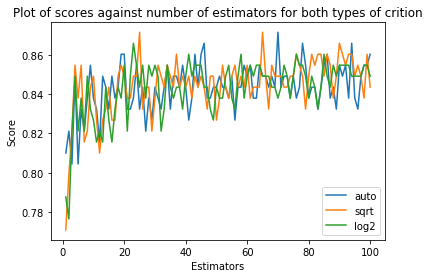

In [32]:
# Erm..., so basically, this is showing the criterion makes very little difference in this case
# You could also change some of the other parameters to look at them instead
# IE, the OOB error
# V. Briefly, what this is, is the error realted to the sample outside of your bootstrapped sample used for the tree
# We could also look at this in terms of the the feature selection


max_features=['auto', 'sqrt', 'log2'] 

scores = []
plt_dict = OrderedDict((label, []) for label in max_features)
for i in max_features:
    for j in n_estimators:
        clf = RandomForestClassifier(n_estimators= j
                            , criterion = 'gini'
                            , max_features = i)
        clf = clf.fit(X=X_train, y=y_train)
        score = clf.score(X=X_test, y=y_test)
        plt_dict[str(i)].append((j, score))
        
# Now plot it
for key, value in plt_dict.items():
    xs, ys = zip(*value)
    plt.plot(xs, ys, label = key)
    
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Plot of scores against number of estimators for both types of crition')
plt.legend()
plt.show()


In [ ]:
# Again, not much differnce between the dif types of feature segmenation. Possibly because of the small dataset
# Possible extensions....
## Look at other forms of enseble modelling techniques (ie, ada boosing) - Adaboosing is a boosting method, random forrest is an averaging method
## Look at Support Vector Machines (SVM) model. This is a way of creating non-linear decision boundries in multi-dimensional space


## When you have a decent model, then run it on the datafile 'test.csv', and submit your result to Kaggle. 
## They will give you back a score, which is an assesment of how good your model is
## For more infomation on what they are looking for, here is the submission page -https://www.kaggle.com/c/titanic#evaluation


# Things I have not touched on, but you can use to help with this exercise
# Root Mean Square Error (RMSE) - This is a very important error metric in machine learning, but not relevant to this task
# Cross Validation - This is also very important, but the OOB error for random forests can mean this is not absolutely neccesary.